# K近傍法 & 教師あり学習のお作法

In [1]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# K近傍法を実行するためのクラス
from sklearn.neighbors import KNeighborsClassifier

# 交差検証を行うためのクラス
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

# 精度，マクロ精度，適合率，AUCを評価するための関数
from sklearn.metrics import balanced_accuracy_score

# データ分割のための関数
from sklearn.model_selection import train_test_split

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline

---

# クイズ

### Q1: 崩し字データのダウンロード

[Kuzushiji-MNIST](https://github.com/rois-codh/kmnist)は，[ROIS-DS人文学オープンデータ共同利用センター](https://codh.rois.ac.jp/index.html.ja)が公開している日本語[くずし字](https://ja.wikipedia.org/wiki/%E3%81%8F%E3%81%9A%E3%81%97%E5%AD%97)の画像データセットである（画像出典:[GitHubのkmnistレポジトリより参照](https://github.com/rois-codh/kmnist)）．

![Kuzushiji MNIST](https://github.com/rois-codh/kmnist/raw/master/images/kmnist_examples.png)

クイズに取り組むに先だって以下のコードを実行し，下記3つのデータファイルをダウンロードしなさい．
- `k49-test-imgs.npz`: （評価用）画像データ
- `k49-test-labels.npz`: （評価用）ラベルデータ
- `k49_classmap.csv`: ラベル数字と文字の対応関係に関するCSVファイル

In [2]:
!curl -o data/k49/k49-test-imgs.npz --create-dirs https://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz
!curl -o data/k49/k49-test-labels.npz --create-dirs https://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz
!curl -o data/k49/k49_classmap.csv --create-dirs http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.4M  100 10.4M    0     0  4721k      0  0:00:02  0:00:02 --:--:-- 4721k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27450  100 27450    0     0   336k      0 --:--:-- --:--:-- --:--:--  339k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   267  100   267    0     0   7990      0 --:--:-- --:--:-- --:--:--  8090


ファイルのダウンロード後，下記コードを実行し，変数`X`に画像データ，変数`y`にラベルデータを格納しなさい．

In [4]:
import numpy as np

X = np.load('data/k49/k49-test-imgs.npz')['arr_0'].reshape(-1, 28 * 28)
y = np.load('data/k49/k49-test-labels.npz')['arr_0']

### Q2: データの確認

変数`X`に格納された2025番目のくずし字を28行28列の行列形式，画像形式のそれぞれで表示せよ．

In [5]:
X[2024, :].reshape(28, 28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  57, 174,  55,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  23, 195, 217,  62,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 106, 251, 211,  36,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1, 165, 255, 193,  16,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         23, 221, 255, 183,   8,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         21, 211, 254, 149,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

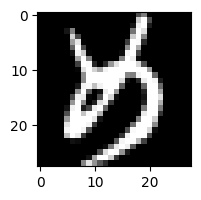

In [6]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(X[2025, :].reshape(28, 28), cmap=plt.cm.gray, interpolation='none')
plt.show()

### Q3: ラベルデータの分布

変数`y`に格納された各ラベルについて，その出現頻度を求めなさい．
なお，`y`のラベルはラベル番号であるため，可能なら`k49_classmap.csv`を用いてラベル番号を文字に置き換えること．

In [7]:
# ラベル番号と文字の対応を読み込む
label_df = pd.read_table('http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv', sep=',')

# ラベル番号->文字の対応関係を示す辞書を作る
idx2moji = {}
for _, row in label_df[['index', 'char']].iterrows():
    idx = row['index']
    moji = row['char']
    idx2moji[idx] = moji
    
idx2moji = {idx: moji for idx, moji in label_df[['index', 'char']].values.tolist()}

# 訓練データの分布
label_indices, counts = np.unique(y, return_counts=True)
for label_idx, count in zip(label_indices, counts):
   print(idx2moji[label_idx], ":", count)

あ : 1000
い : 1000
う : 1000
え : 126
お : 1000
か : 1000
き : 1000
く : 1000
け : 767
こ : 1000
さ : 1000
し : 1000
す : 1000
せ : 678
そ : 629
た : 1000
ち : 418
つ : 1000
て : 1000
と : 1000
な : 1000
に : 1000
ぬ : 336
ね : 399
の : 1000
は : 1000
ひ : 836
ふ : 1000
へ : 1000
ほ : 324
ま : 1000
み : 498
む : 280
め : 552
も : 1000
や : 1000
ゆ : 260
よ : 1000
ら : 1000
り : 1000
る : 1000
れ : 1000
ろ : 348
わ : 390
ゐ : 68
ゑ : 64
を : 1000
ん : 1000
ゝ : 574


### Q4: くずし字画像分類に対するK近傍法の瀬能
変数`X`，`y`とK近傍法を用いて，くずし字画像の分類器を構築し，交差検証によって分類性能を評価しなさい．
なお，K近傍法のパラメータ`K`は5，交差検証時のデータ分割数は`5`としなさい．

In [8]:
# 5分割「層別化」交差検証の準備（乱数を固定）
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（マクロ精度（balanced accuracy））
score_func = ['balanced_accuracy']

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_func)
print("Balanced accuracy: ", np.mean(scores['test_balanced_accuracy']))

Balanced accuracy:  0.7633174794231443


### Q5: 最適パラメータの探索
Q4で構築したくずし字画像分類器について，K近傍法のパラメータ`K`を2から9までひとつずつ変化させながら分類性能を評価し，最適なパラメータ`K`を求めなさい．

In [9]:
for K in range(2, 10):
    # 5分割「層別化」交差検証の準備（乱数を固定）
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
    
    # 評価指標（マクロ精度（balanced accuracy））
    score_func = ['balanced_accuracy']
    
    # K近傍法のモデルの定義
    knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")
    
    # 交差検証をしながら分類器を構築・評価
    scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_func)
    print(f"Balanced accuracy on K = {K}: ", np.mean(scores['test_balanced_accuracy']))

Balanced accuracy on K = 2:  0.7502007486114307
Balanced accuracy on K = 3:  0.7658574699985454
Balanced accuracy on K = 4:  0.7636780038490381
Balanced accuracy on K = 5:  0.7633174794231443
Balanced accuracy on K = 6:  0.7573289368903839
Balanced accuracy on K = 7:  0.7521916169828297
Balanced accuracy on K = 8:  0.7456691544554975
Balanced accuracy on K = 9:  0.7428928634345946
